In [1]:
import numpy as np 
import pandas as pd 
import itertools
import fnmatch
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from glob import glob
from skimage import io
from os import listdir
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import History
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pickle
from keras.models import load_model
from tensorflow.keras import layers

Using TensorFlow backend.


In [2]:
imagePatches = glob('./IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:5]:
    print(filename)

./IDC_regular_ps50_idx5/9036/0/9036_idx5_x1051_y2401_class0.png
./IDC_regular_ps50_idx5/9036/0/9036_idx5_x2951_y951_class0.png
./IDC_regular_ps50_idx5/9036/0/9036_idx5_x3001_y1451_class0.png
./IDC_regular_ps50_idx5/9036/0/9036_idx5_x3051_y801_class0.png
./IDC_regular_ps50_idx5/9036/0/9036_idx5_x951_y1901_class0.png


In [3]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:3],'\n')
print("IDC(+)\n\n",classOne[0:2])

IDC(-)

 ['./IDC_regular_ps50_idx5/9036/0/9036_idx5_x1051_y2401_class0.png', './IDC_regular_ps50_idx5/9036/0/9036_idx5_x2951_y951_class0.png', './IDC_regular_ps50_idx5/9036/0/9036_idx5_x3001_y1451_class0.png'] 

IDC(+)

 ['./IDC_regular_ps50_idx5/9036/1/9036_idx5_x1851_y1351_class1.png', './IDC_regular_ps50_idx5/9036/1/9036_idx5_x1851_y1451_class1.png']


In [4]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

In [5]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    channels = 3
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [6]:
X,Y = proc_images(0,150000)

In [7]:
X=np.array(X)
X= X.astype(np.float32)
X/=255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1984)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (120000, 50, 50, 3)
Testing Data Shape: (30000, 50, 50, 3)


In [8]:
Y_train.count(0), Y_train.count(1)

(89280, 30720)

In [9]:
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [10]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

In [11]:
from imblearn.under_sampling import RandomUnderSampler
random_under_sampler = RandomUnderSampler()
X_trainRos, Y_trainRos = random_under_sampler.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = random_under_sampler.fit_sample(X_testFlat, Y_test)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [12]:
Y_trainRosHot = to_categorical(Y_trainRos, num_classes=2)
Y_testRosHot = to_categorical(Y_testRos, num_classes=2)

In [13]:
np.unique(Y_trainRos, return_counts=True)

(array([0, 1]), array([30720, 30720]))

In [14]:
for i in range(len(X_trainRos)):
    height, width, channels = 50, 50, 3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos), height, width, channels)

In [15]:
for i in range(len(X_testRos)):
    height, width, channels = 50, 50, 3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos), height, width, channels)

In [34]:
batch_size = 256
num_classes = 2
epochs = 30
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3),activation='relu',input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten()) 
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

In [35]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=.00001),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 22, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 256)         295168    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 512)        

In [31]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True) 

In [36]:
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
training = model.fit_generator(datagen.flow(X_trainRosReshaped,Y_trainRosHot,batch_size=batch_size),
                steps_per_epoch=len(X_trainRosReshaped) / batch_size, epochs=epochs,validation_data=(X_testRosReshaped, Y_testRosHot),
                verbose=1, callbacks=[early_stopping_monitor, model_checkpoint])

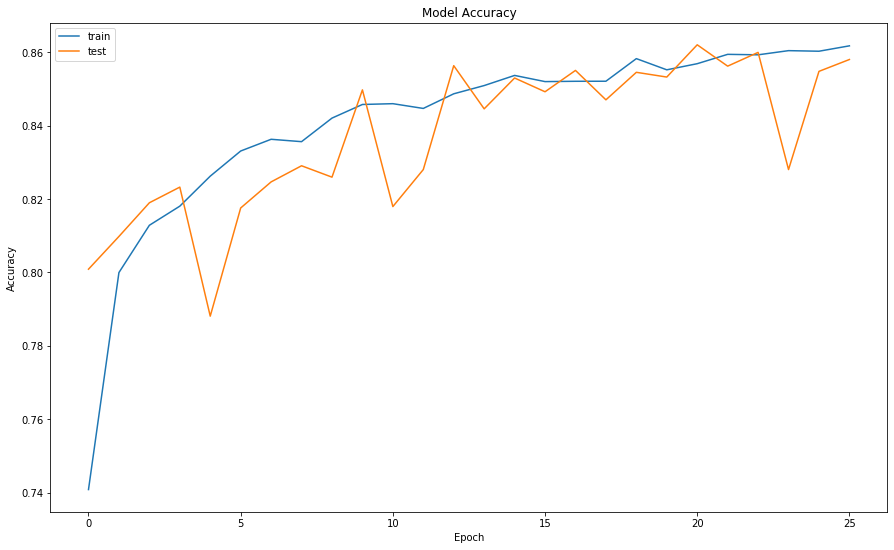

In [22]:
plt.figure(figsize=(15,9))
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

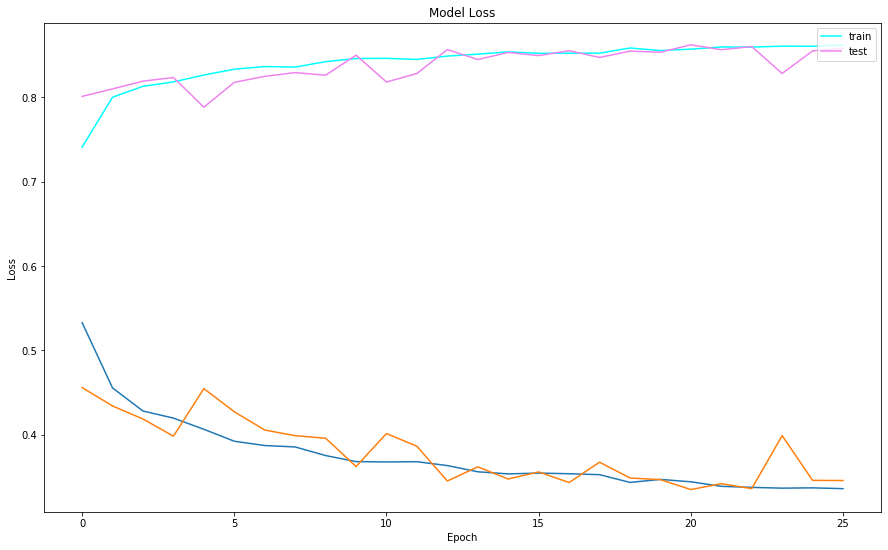

In [31]:
plt.figure(figsize=(15,9))
plt.plot(training.history['accuracy'], color='cyan')
plt.plot(training.history['val_accuracy'], color='violet')
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper right')

In [24]:
y_pred_one_hot = model.predict(X_testRosReshaped)
y_pred_labels = np.argmax(y_pred_one_hot, axis = 1)
y_true_labels = np.argmax(Y_testRosHot,axis=1)
confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(confusion_matrix)

[[3363  504]
 [ 594 3273]]


In [29]:
model = load_model('best_model.h5')

preds = model.predict(X_testRosReshaped)
y_pred_labels = np.argmax(preds, axis = 1)

y_true_labels = np.argmax(Y_testRosHot,axis=1)

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)
print(confusion_matrix)

[[3371  496]
 [ 571 3296]]


In [30]:
preds

array([[0.48458263, 0.52693546],
       [0.80063784, 0.19938436],
       [0.8320086 , 0.16984871],
       ...,
       [0.2121723 , 0.79273736],
       [0.03586618, 0.9659525 ],
       [0.18072121, 0.8234247 ]], dtype=float32)